In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm

import requests
import zipfile
import os

In [27]:
import requests
import zipfile
import io
import pandas as pd
from datetime import datetime

date = "2025-07-07"
symbol = "BTCUSDT"
interval = "1s"
url = f"https://data.binance.vision/data/spot/daily/klines/{symbol}/{interval}/{symbol}-{interval}-{date}.zip"

r = requests.get(url)
with zipfile.ZipFile(io.BytesIO(r.content)) as z:
    z.extractall("/tmp/binance_1s_data")

print("Kline download complete.")

file_path = f"/tmp/binance_1s_data/{symbol}-{interval}-{date}.csv"

cols = [
    "OpenTime", "Open", "High", "Low", "Close", "Volume",
    "CloseTime", "QuoteAssetVolume", "NumTrades",
    "TakerBuyBaseVolume", "TakerBuyQuoteVolume", "Ignore"
]
BTC_Data = pd.read_csv(file_path, header=None, names=cols)

times = pd.date_range(start=f"{date} 00:00:00", end=f"{date} 23:59:59", freq='s')

BTC_Data['OpenTime'] = times

BTC_Data["Midprice"] = (BTC_Data["High"] + BTC_Data["Low"]) / 2

print(BTC_Data.head())

trade_url = f"https://data.binance.vision/data/spot/daily/trades/{symbol}/{symbol}-trades-{date}.zip"
r = requests.get(trade_url)
with zipfile.ZipFile(io.BytesIO(r.content)) as z:
    z.extractall("/tmp/binance_trades")

print("Trade download complete.")





Kline download complete.
             OpenTime       Open      High        Low      Close   Volume  \
0 2025-07-07 00:00:00  109203.85  109210.0  109203.84  109210.00  1.77611   
1 2025-07-07 00:00:01  109209.99  109210.0  109209.99  109209.99  0.00395   
2 2025-07-07 00:00:02  109209.99  109210.0  109209.99  109210.00  0.01512   
3 2025-07-07 00:00:03  109210.00  109210.0  109209.99  109210.00  0.00382   
4 2025-07-07 00:00:04  109210.00  109215.1  109209.99  109215.10  0.57115   

          CloseTime  QuoteAssetVolume  NumTrades  TakerBuyBaseVolume  \
0  1751846400999999     193958.928716        230             1.77258   
1  1751846401999999        431.379461          3             0.00006   
2  1751846402999999       1651.255173          8             0.01242   
3  1751846403999999        417.182195          6             0.00336   
4  1751846404999999      62375.908274        117             0.57080   

   TakerBuyQuoteVolume  Ignore    Midprice  
0        193573.427011       0  10

In [28]:
trade_file = f"/tmp/binance_trades/{symbol}-trades-{date}.csv"
trade_columns = ["TradeID", "Price", "Qty", "QuoteQty", "Time", "IsBuyerMaker", "IsBestMatch"]
BTC_Trade_Data = pd.read_csv(trade_file, header=None, names=trade_columns)

BTC_Trade_Data

,TradeID,Price,Qty,QuoteQty,Time,IsBuyerMaker,IsBestMatch
0,5066445577,109203.85,0.00041,44.773578,1751846400147543,False,True
1,5066445578,109203.84,0.00151,164.897798,1751846400198800,True,True
2,5066445579,109203.85,0.00027,29.485039,1751846400374105,False,True
3,5066445580,109203.85,0.00045,49.141733,1751846400405424,False,True
4,5066445581,109203.85,0.00457,499.061595,1751846400433512,False,True
...,...,...,...,...,...,...,...
1961935,5068407512,108262.95,0.00074,80.114583,1751932798578226,False,True
1961936,5068407513,108262.94,0.10577,11450.971164,1751932798729300,True,True
1961937,5068407514,108262.94,0.00903,977.614348,1751932798923779,True,True
1961938,5068407515,108262.94,0.00007,7.578406,1751932799588881,True,True


QQ Plot of the Midprice

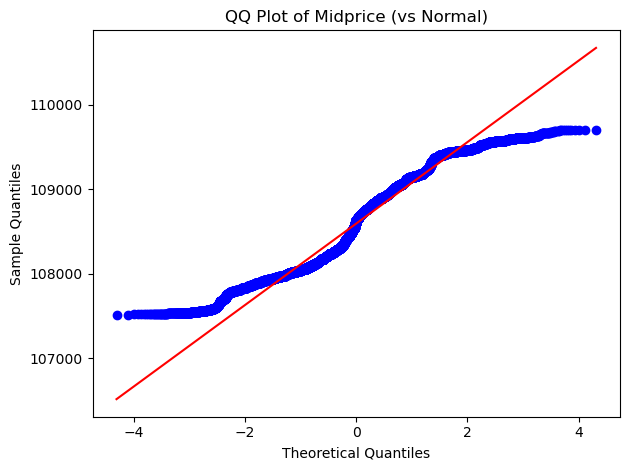

In [29]:
Midprice = BTC_Data['Midprice']

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


x = Midprice.to_numpy(dtype=float)          
x = x[np.isfinite(x)]                       

fig, ax = plt.subplots()
stats.probplot(x, dist="norm", plot=ax)     
ax.set_title("QQ Plot of Midprice (vs Normal)")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Quantiles")
plt.tight_layout()
plt.show()


Estimating A and k

In [30]:
BTC_Trade_Data["Real_Time"] = pd.to_datetime(BTC_Trade_Data["Time"] // 1000, unit="ms")
BTC_Trade_Data["BidPrice"] = np.where(BTC_Trade_Data["IsBuyerMaker"], BTC_Trade_Data["Price"], np.nan)
BTC_Trade_Data["AskPrice"] = np.where(~BTC_Trade_Data["IsBuyerMaker"], BTC_Trade_Data["Price"], np.nan)

BTC_Trade_Data["BestBid"] = BTC_Trade_Data["BidPrice"].ffill()
BTC_Trade_Data["BestAsk"] = BTC_Trade_Data["AskPrice"].ffill()

BTC_Trade_Data["Midprice"] = (BTC_Trade_Data["BestBid"] + BTC_Trade_Data["BestAsk"]) / 2

BTC_Trade_Data = BTC_Trade_Data.dropna(subset=["Midprice"])
BTC_Trade_Data['Delta'] = np.abs(BTC_Trade_Data['Price']-BTC_Trade_Data['Midprice'])

BTC_Trade_Data

/var/folders/jy/87j_16fd60gcff9mzn9wmhjr0000gq/T/ipykernel_34091/1287082753.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BTC_Trade_Data['Delta'] = np.abs(BTC_Trade_Data['Price']-BTC_Trade_Data['Midprice'])


,TradeID,Price,Qty,QuoteQty,Time,IsBuyerMaker,IsBestMatch,Real_Time,BidPrice,AskPrice,BestBid,BestAsk,Midprice,Delta
1,5066445578,109203.84,0.00151,164.897798,1751846400198800,True,True,2025-07-07 00:00:00.198,109203.84,NaN,109203.84,109203.85,109203.845,0.005
2,5066445579,109203.85,0.00027,29.485039,1751846400374105,False,True,2025-07-07 00:00:00.374,NaN,109203.85,109203.84,109203.85,109203.845,0.005
3,5066445580,109203.85,0.00045,49.141733,1751846400405424,False,True,2025-07-07 00:00:00.405,NaN,109203.85,109203.84,109203.85,109203.845,0.005
4,5066445581,109203.85,0.00457,499.061595,1751846400433512,False,True,2025-07-07 00:00:00.433,NaN,109203.85,109203.84,109203.85,109203.845,0.005
5,5066445582,109203.85,0.00114,124.492389,1751846400447349,False,True,2025-07-07 00:00:00.447,NaN,109203.85,109203.84,109203.85,109203.845,0.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1961935,5068407512,108262.95,0.00074,80.114583,1751932798578226,False,True,2025-07-07 23:59:58.578,NaN,108262.95,108262.94,108262.95,108262.945,0.005
1961936,5068407513,108262.94,0.10577,11450.971164,1751932798729300,True,True,2025-07-07 23:59:58.729,108262.94,NaN,108262.94,108262.95,108262.945,0.005
1961937,5068407514,108262.94,0.00903,977.614348,1751932798923779,True,True,2025-07-07 23:59:58.923,108262.94,NaN,108262.94,108262.95,108262.945,0.005
1961938,5068407515,108262.94,0.00007,7.578406,1751932799588881,True,True,2025-07-07 23:59:59.588,108262.94,NaN,108262.94,108262.95,108262.945,0.005


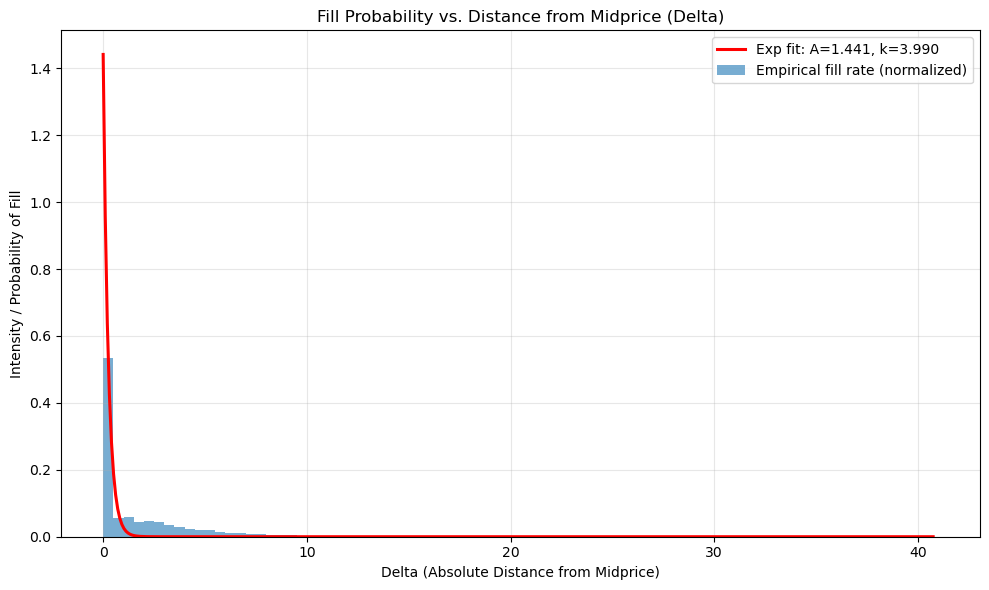

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


max_delta = float(BTC_Trade_Data["Delta"].max())
max_delta_int = int(np.ceil(max_delta)) 
bins = np.arange(0, max_delta_int + 0.5, 0.5) 
delta_cats = pd.cut(BTC_Trade_Data["Delta"], bins)


counts = delta_cats.value_counts(sort=False)      
probs = (counts / counts.sum()).to_numpy()        
bin_centres = np.array([iv.mid for iv in counts.index]) 


def trading_intensity(delta, A, k):
    return A * np.exp(-k * delta)

mask = probs > 0
x = bin_centres
y = probs

p0 = (y.max(), 1.0) 
bounds = (0, np.inf)
popt, pcov = curve_fit(trading_intensity, x, y)
A, k = popt

x_values = np.linspace(0, bin_centres.max(), 400)
y_fit = trading_intensity(x_values, A, k)

plt.figure(figsize=(10, 6))
plt.bar(bin_centres, probs, width=0.5, alpha=0.6, label="Empirical fill rate (normalized)")
plt.plot(x_values, y_fit, color='red', linewidth=2.2, label=f"Exp fit: A={A:.3f}, k={k:.3f}")
plt.title("Fill Probability vs. Distance from Midprice (Delta)")
plt.xlabel("Delta (Absolute Distance from Midprice)")
plt.ylabel("Intensity / Probability of Fill")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Generating Constant Volatility

In [32]:
BTC_Data_Midprice = BTC_Trade_Data['Midprice']
BTC_Data_LogReturns = np.log(BTC_Data_Midprice / BTC_Data_Midprice.shift(1)).dropna()
sigma = BTC_Data_LogReturns.std()

In [33]:
sigma

3.1956923434038963e-06

Exporting the times from NYSE Open

In [34]:
start = pd.Timestamp("2025-07-07 13:30:00")
end = pd.Timestamp("2025-07-07 13:33:59")

NYSE_Open = BTC_Data[(BTC_Data["OpenTime"] >= start) & (BTC_Data["OpenTime"] <= end)]
NYSE_Open = NYSE_Open.reset_index(drop=True)

NYSE_Open_Midprice = NYSE_Open['Midprice']

NYSE_Open_Midprice

LogReturns_NYSE_Open = np.log(NYSE_Open_Midprice / NYSE_Open_Midprice.shift(1))
LogReturns_NYSE_Open = LogReturns_NYSE_Open.dropna()

NYSE_Open
len(NYSE_Open_Midprice)
Midprice = NYSE_Open_Midprice

Midprice
sigma


3.1956923434038963e-06

Implementing the model with constant volatility

In [35]:
def simulate_market_making(Midprice, sigma, gamma, A, k, num_paths, strategy_type):
    Midprice = np.array(Midprice)
    T = len(Midprice)
    dt = 1
    N = T - 1  


    def indifference_price(s, q, t):
        return s - q * gamma * sigma**2 * (T - t)

    def optimal_spread(t):
        return gamma * sigma**2 * (T - t) + (2 / gamma) * np.log(1 + gamma / k)

    def bid_ask_quotes_inventory(s, q, t):
        r = indifference_price(s, q, t)
        spread = optimal_spread(t)
        return r - spread/2, r + spread/2, r

    def bid_ask_quotes_symmetric(s, t):
        spread = optimal_spread(t)
        return s - spread/2, s + spread/2, s

    def order_probability(delta):
        return A * np.exp(-k * delta) * dt


    profits = []
    final_inventories = []

    for path in range(num_paths):
        inventory = 0
        wealth = 0.0

        for t in range(N):
            s_t = Midprice[t]
            time = t * dt

            if strategy_type == "inventory":
                p_b, p_a, _ = bid_ask_quotes_inventory(s_t, inventory, time)
            elif strategy_type == "symmetric":
                p_b, p_a, _ = bid_ask_quotes_symmetric(s_t, time)
            else:
                raise ValueError("Invalid strategy_type. Choose 'inventory' or 'symmetric'.")

            delta_b = s_t - p_b
            delta_a = p_a - s_t

            if np.random.rand() < order_probability(delta_b):
                inventory += 1
                wealth -= p_b
            if np.random.rand() < order_probability(delta_a):
                inventory -= 1
                wealth += p_a

        final_wealth = wealth + inventory * Midprice[-1]
        profits.append(final_wealth)
        final_inventories.append(inventory)

    profits = np.array(profits)
    final_inventories = np.array(final_inventories)
    abs_inventories = np.abs(final_inventories)

    spread = gamma * sigma**2 * T + (2 / gamma) * np.log(1 + gamma / k)
    avg_pnl = profits.mean()
    std_pnl = profits.std()
    avg_abs_inventory = abs_inventories.mean()
    std_abs_inventory = abs_inventories.std()
    sharpe_ratio = avg_pnl / std_pnl if std_pnl > 0 else np.nan

    return {
        "gamma": gamma,
        "strategy": strategy_type,
        "spread": spread,
        "avg_pnl": avg_pnl,
        "std_pnl": std_pnl,
        "avg_abs_inventory": avg_abs_inventory,
        "std_abs_inventory": std_abs_inventory,
        "sharpe_ratio": sharpe_ratio
    }

In [36]:
gamma_values = np.linspace(0.1,1,100)

results_inventory = []
results_symmetric = []

for gamma in gamma_values:
    result_inv = simulate_market_making(Midprice, sigma, gamma, A, k, 1000, strategy_type="inventory")
    result_sym = simulate_market_making(Midprice, sigma, gamma, A, k, 1000, strategy_type="symmetric")
    results_inventory.append(result_inv)
    results_symmetric.append(result_sym)

In [37]:
df_inventory = pd.DataFrame(results_inventory).set_index("gamma")
df_symmetric = pd.DataFrame(results_symmetric).set_index("gamma")

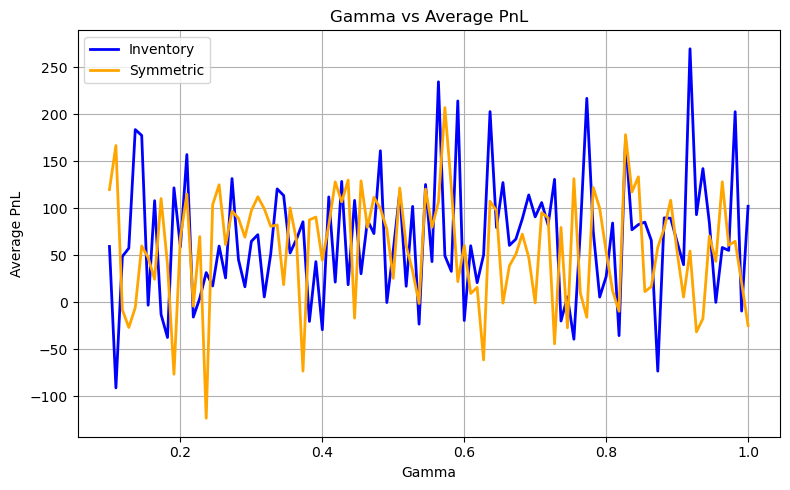

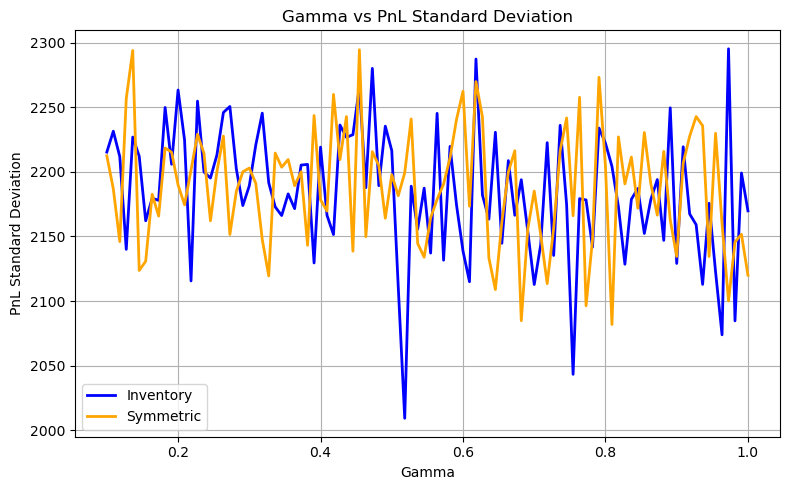

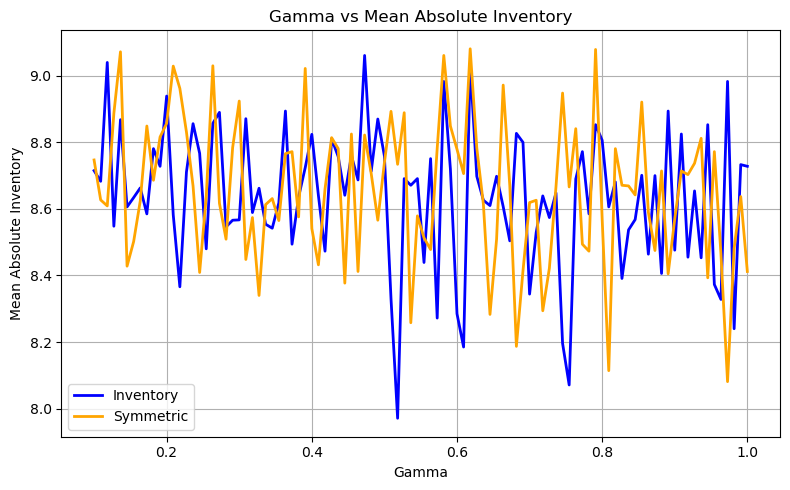

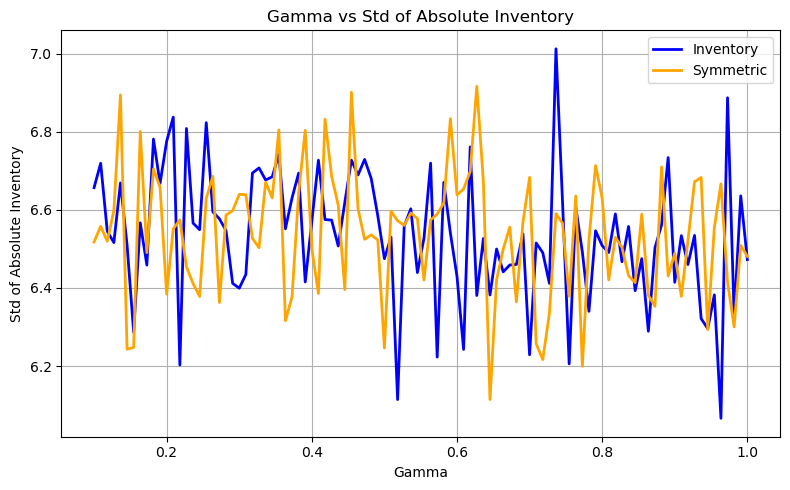

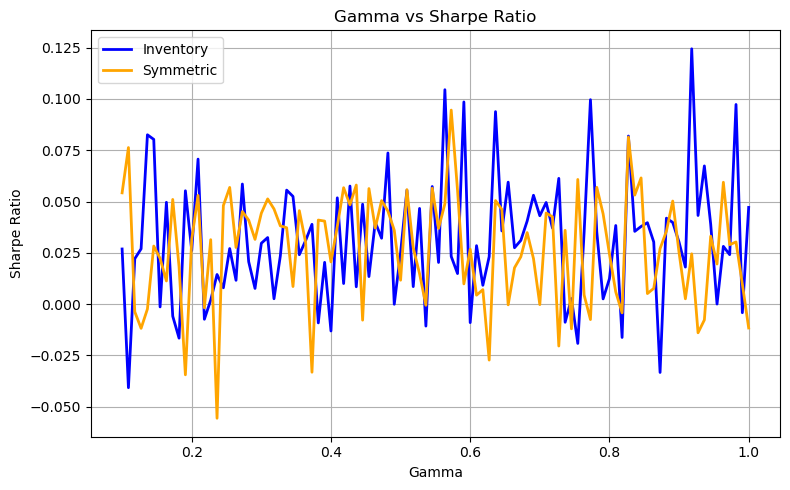

In [38]:
def plot_metric(metric_name, ylabel):
    plt.figure(figsize=(8, 5))
    plt.plot(gamma_values, df_inventory[metric_name], label="Inventory", color='blue', linewidth=2)
    plt.plot(gamma_values, df_symmetric[metric_name], label="Symmetric", color='orange', linewidth=2)
    plt.xlabel("Gamma")
    plt.ylabel(ylabel)
    plt.title(f"Gamma vs {ylabel}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metric("avg_pnl", "Average PnL")
plot_metric("std_pnl", "PnL Standard Deviation")
plot_metric("avg_abs_inventory", "Mean Absolute Inventory")
plot_metric("std_abs_inventory", "Std of Absolute Inventory")
plot_metric("sharpe_ratio", "Sharpe Ratio")

GARCH(1,1) Implementation and Analysis

In [39]:
from arch import arch_model

Proving the Lack of Normality in the Log Returns

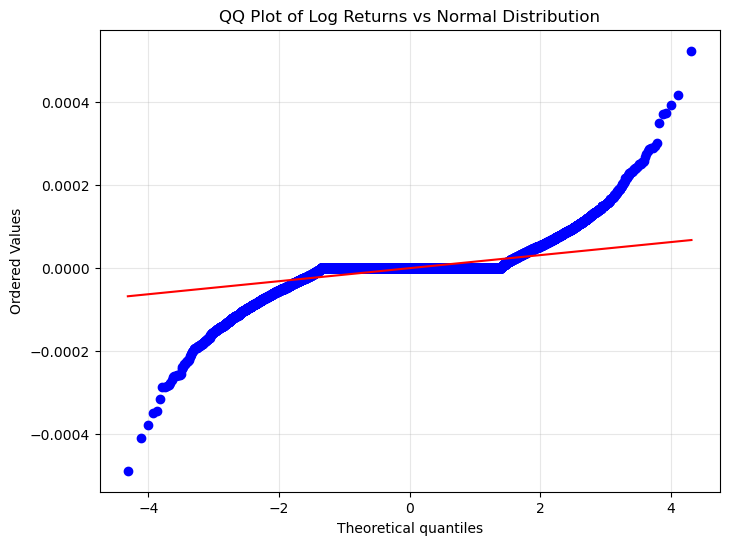

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


log_returns = np.log(BTC_Data['Midprice']).diff().dropna()

plt.figure(figsize=(8, 6))
stats.probplot(log_returns, dist="norm", plot=plt)
plt.title("QQ Plot of Log Returns vs Normal Distribution")
plt.grid(True, alpha=0.3)
plt.show()

GARCH Model Fitting

In [41]:
import numpy as np
from arch import arch_model

log_returns = np.log(BTC_Data['Midprice']).diff().dropna() * 100  # percent units

garch_model = arch_model(
    log_returns,
    mean="Constant",     
    vol="GARCH",         
    p=1, q=1,            
    dist="t"             
)

garch_fit = garch_model.fit(disp="off")
print(garch_fit.summary())


garch_vol = garch_fit.conditional_volatility  

BTC_Data = BTC_Data.iloc[1:].copy()  
BTC_Data["GARCH_vol"] = garch_vol.values

/Users/mattiemalik/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.418e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mattiemalik/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                     Midprice   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                462736.
Distribution:      Standardized Student's t   AIC:                          -925462.
Method:                  Maximum Likelihood   BIC:                          -925415.
                                              No. Observations:                86399
Date:                      Thu, Aug 28 2025   Df Residuals:                    86398
Time:                              12:01:31   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------

In [42]:

print(garch_fit.params)

nu_hat = garch_fit.params["nu"]
print(f"Estimated Student-t degrees of freedom: {nu_hat:.2f}")

mu         -1.004819e-05
omega       5.418472e-07
alpha[1]    2.000000e-01
beta[1]     7.000000e-01
nu          4.100111e+00
Name: params, dtype: float64
Estimated Student-t degrees of freedom: 4.10


In [43]:
start = pd.Timestamp("2025-07-07 13:30:00")
end = pd.Timestamp("2025-07-07 13:33:59")

NYSE_Open = BTC_Data[(BTC_Data["OpenTime"] >= start) & (BTC_Data["OpenTime"] <= end)]
NYSE_Open = NYSE_Open.reset_index(drop=True)

Midprice = NYSE_Open['Midprice']

NYSE_Open

garch_vol = NYSE_Open['GARCH_vol']

Implementing the strategies with GARCH Volatility

In [44]:
def simulate_market_making(Midprice, garch_vol, gamma, A, k, num_paths, strategy_type):
    Midprice = np.array(Midprice)
    garch_vol = np.array(garch_vol)

    T = len(Midprice)
    dt = 1
    N = T - 1  

    def indifference_price(s, q, t, sigma_t):
        return s - q * gamma * sigma_t**2 * (T - t)

    def optimal_spread(t, sigma_t):
        return gamma * sigma_t**2 * (T - t) + (2 / gamma) * np.log(1 + gamma / k)

    def bid_ask_quotes_inventory(s, q, t, sigma_t):
        r = indifference_price(s, q, t, sigma_t)
        spread = optimal_spread(t, sigma_t)
        return r - spread/2, r + spread/2, r

    def bid_ask_quotes_symmetric(s, t, sigma_t):
        spread = optimal_spread(t, sigma_t)
        return s - spread/2, s + spread/2, s

    def order_probability(delta):
        return A * np.exp(-k * delta) * dt

    profits = []
    final_inventories = []

    for path in range(num_paths):
        inventory = 0
        wealth = 0.0

        for t in range(N):
            s_t = Midprice[t]
            sigma_t = garch_vol[t]
            time = t * dt

            if strategy_type == "inventory":
                p_b, p_a, _ = bid_ask_quotes_inventory(s_t, inventory, time, sigma_t)
            elif strategy_type == "symmetric":
                p_b, p_a, _ = bid_ask_quotes_symmetric(s_t, time, sigma_t)
            else:
                raise ValueError("Invalid strategy_type. Choose 'inventory' or 'symmetric'.")

            delta_b = s_t - p_b
            delta_a = p_a - s_t

            if np.random.rand() < order_probability(delta_b):
                inventory += 1
                wealth -= p_b
            if np.random.rand() < order_probability(delta_a):
                inventory -= 1
                wealth += p_a

        final_wealth = wealth + inventory * Midprice[-1]
        profits.append(final_wealth)
        final_inventories.append(inventory)


    profits = np.array(profits)
    final_inventories = np.array(final_inventories)
    abs_inventories = np.abs(final_inventories)

    avg_sigma_squared = np.mean(np.square(garch_vol))
    spread = gamma * avg_sigma_squared * T + (2 / gamma) * np.log(1 + gamma / k)

    avg_pnl = profits.mean()
    std_pnl = profits.std()
    avg_abs_inventory = abs_inventories.mean()
    std_abs_inventory = abs_inventories.std()
    sharpe_ratio = avg_pnl / std_pnl if std_pnl > 0 else np.nan

    return {
        "gamma": gamma,
        "strategy": strategy_type,
        "spread": spread,
        "avg_pnl": avg_pnl,
        "std_pnl": std_pnl,
        "avg_abs_inventory": avg_abs_inventory,
        "std_abs_inventory": std_abs_inventory,
        "sharpe_ratio": sharpe_ratio
    }

In [45]:
gamma_values = np.linspace(0.1,1,100)

results_inventory = []
results_symmetric = []

for gamma in gamma_values:
    result_inv = simulate_market_making(Midprice, garch_vol, gamma, A, k, 1000, strategy_type="inventory")
    result_sym = simulate_market_making(Midprice, garch_vol, gamma, A, k, 1000, strategy_type="symmetric")
    results_inventory.append(result_inv)
    results_symmetric.append(result_sym)


In [46]:
df_inventory = pd.DataFrame(results_inventory).set_index("gamma")
df_symmetric = pd.DataFrame(results_symmetric).set_index("gamma")

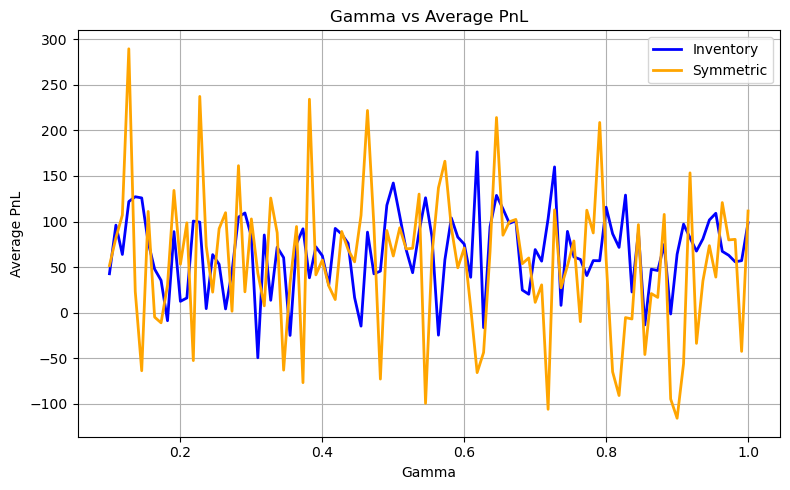

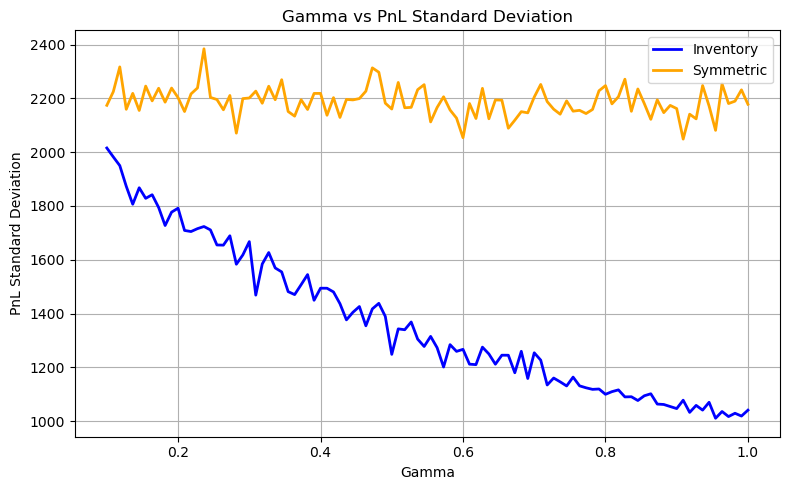

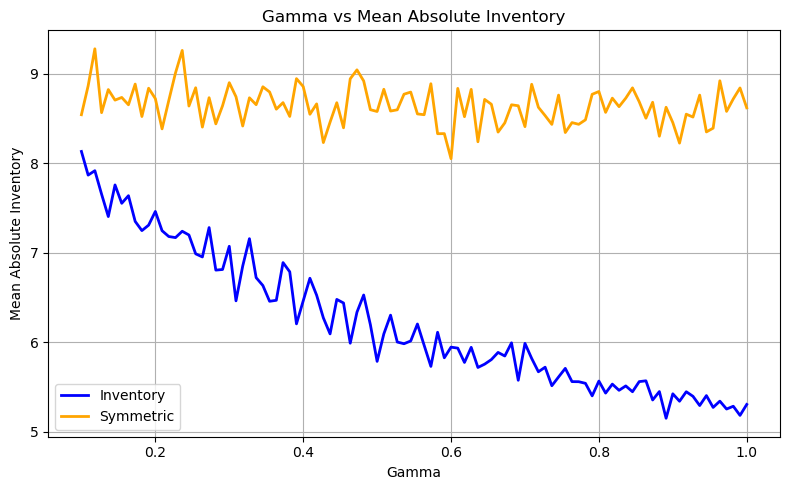

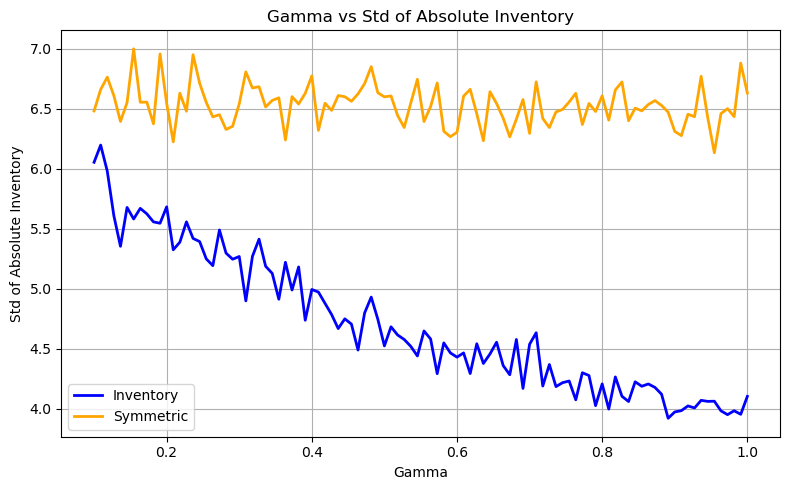

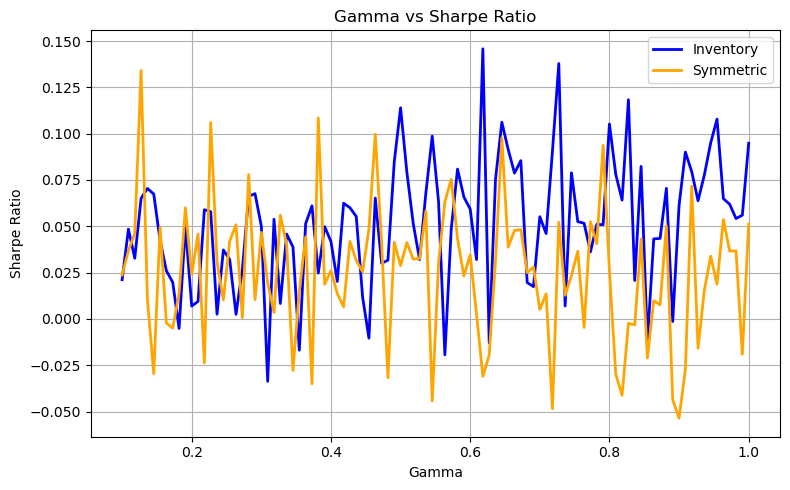

In [47]:
def plot_metric(metric_name, ylabel):
    plt.figure(figsize=(8, 5))
    plt.plot(gamma_values, df_inventory[metric_name], label="Inventory", color='blue', linewidth=2)
    plt.plot(gamma_values, df_symmetric[metric_name], label="Symmetric", color='orange', linewidth=2)
    plt.xlabel("Gamma")
    plt.ylabel(ylabel)
    plt.title(f"Gamma vs {ylabel}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metric("avg_pnl", "Average PnL")
plot_metric("std_pnl", "PnL Standard Deviation")
plot_metric("avg_abs_inventory", "Mean Absolute Inventory")
plot_metric("std_abs_inventory", "Std of Absolute Inventory")
plot_metric("sharpe_ratio", "Sharpe Ratio")

Showing the Volatility Dependent Spread Dynamics

In [48]:
Time = np.arange(1,len(BTC_Data)+1)
GARCH_Vol = BTC_Data['GARCH_vol']

In [49]:

T = len(BTC_Data)

Time = np.arange(1, len(BTC_Data) + 1)
GARCH_vol_np = BTC_Data['GARCH_vol'].to_numpy()  
tau = (T - Time).astype(float)                    

def spread_vector(gamma, sigma, tau, k=1.0):
    return gamma * (sigma**2) * tau + (2.0 / gamma) * np.log(1.0 + gamma / k)

Spread_vals_01 = spread_vector(0.1, GARCH_vol_np, tau, k=k)



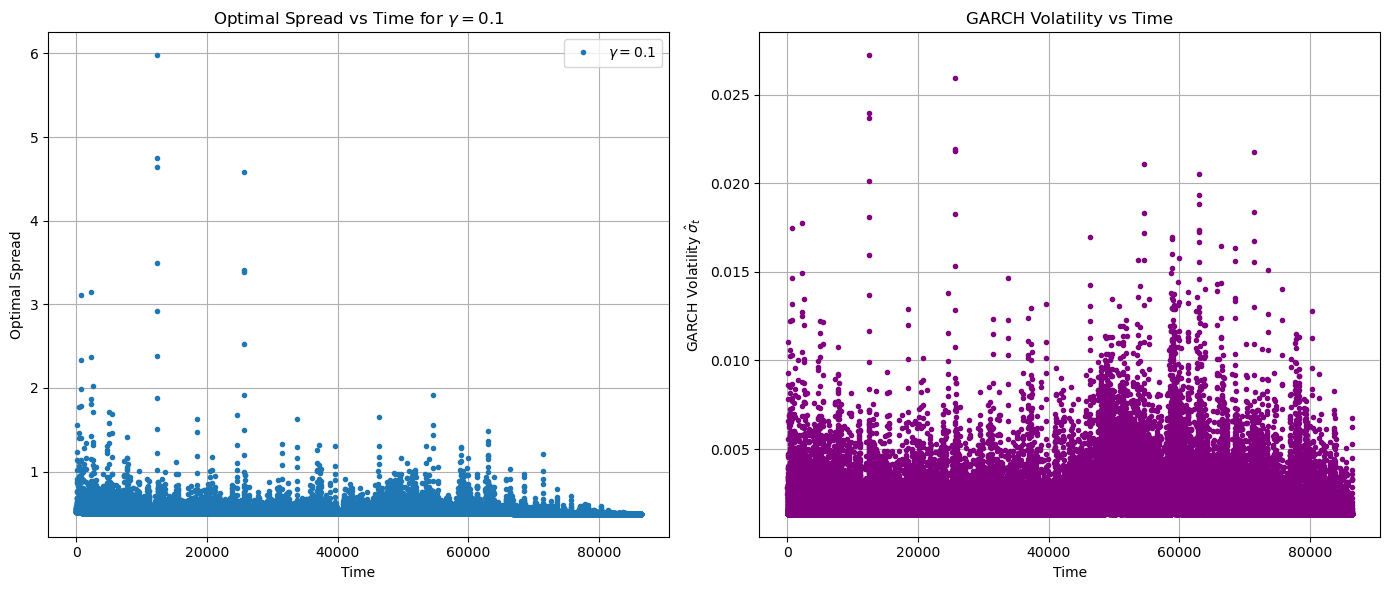

In [50]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(Time, Spread_vals_01, label=r'$\gamma = 0.1$', 
             linestyle='None', marker='o', markersize=3)

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Optimal Spread")
axes[0].set_title("Optimal Spread vs Time for $\gamma = 0.1$")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(Time, GARCH_Vol, color="purple", marker='o', linestyle='None', markersize=3)
axes[1].set_xlabel("Time")
axes[1].set_ylabel("GARCH Volatility $\\hat{\\sigma}_t$")
axes[1].set_title("GARCH Volatility vs Time")
axes[1].grid(True)

plt.tight_layout()
plt.show()

Testing the Two Strategies against the BTC Buy and Hold